# Test the performance of the model

## Occurrence of symmetry equivalent structures

### Binary Quadratic Model

In [1]:
from quantum_computing_functions import *
from quantum_computing_postprocessing import *

import numpy as np
import pandas as pd

from pymatgen.core.structure import Structure
from pymatgen.symmetry.analyzer import SpacegroupAnalyzer
from pymatgen.io.ase import AseAtomsAdaptor

from ase.visualize import view

In [2]:
from pymatgen.core.structure import Structure
from pymatgen.symmetry.analyzer import SpacegroupAnalyzer
import copy

lattice = np.array([[ 1.233862, -2.137112,  0.      ],
                   [ 1.233862,  2.137112,  0.      ],
                   [ 0.      ,  0.      ,  8.685038]])

graphene = Structure(lattice, species=['C','C'], coords=[[2/3, 1/3, 0. ],[1/3, 2/3, 0.]])
graphene = SpacegroupAnalyzer(graphene).get_conventional_standard_structure()

n_supercell = 3
scaling_matrix = np.identity(3)*n_supercell
scaling_matrix[2][2] = 1
graphene_supercell = copy.deepcopy(graphene)
graphene_supercell.make_supercell(scaling_matrix)
graphene_supercell.num_sites

18

### Tests:
- chain_break_fracion, number of energy values, number of occurences (1v) 
- vs
- num_cycles, chain strength, cell size

# Loop

In [62]:
#for lagrange in [10,50,100,500,1000]:   
#for num_reads in [100,500,1000,1500,2000,2500]:   
#for vac in [1]:
#for r in [10]:
for ratio in [1,1,10,10]:
    structure = graphene_supercell
    use_coord = False
    num_vacancies=3
    weight_1 = 1
    weight_2 = 0
    lagrange =     weight_1 * ratio
    num_reads = 1000
    file_path = 'data/test'
    file_name = 'graphene'
    remove_broken_chains = False
    chain_strength = None

    #print(lagrange,weight_1)
    bqm = build_quadratic_model(structure,use_coord=use_coord,weight_1=weight_1,weight_2=weight_2,
                                 lagrange=lagrange, num_vacancies=num_vacancies)

    #cqm = build_constrained_quadratic_model(structure,use_coord = use_coord, num_vacancies = num_vacancies, 
                      #weight_1=weight_1, weight_2 = weight_2, lagrange = lagrange)

    sampleset = run_anneal(bqm,dataframe = False, num_reads=num_reads, 
                                           return_config_E=False,remove_broken_chains=remove_broken_chains)

    #dataframe = run_anneal(cqm,num_reads=num_reads, return_config_E=False,remove_broken_chains=remove_broken_chains)


    #save cqm
    '''save_json(structure,dataframe,cqm,use_coord=use_coord, num_vacancies=num_vacancies, 
          weight_1=weight_1, weight_2=weight_2, lagrange=lagrange, num_reads=num_reads,
          remove_broken_chains = remove_broken_chains,
          file_path=file_path, file_name=file_name, save_qubo=False)
    '''

    #save bqm
    save_json(structure,sampleset,bqm,use_coord=use_coord, num_vacancies=num_vacancies, 
      weight_1=weight_1, weight_2=weight_2, lagrange=lagrange, num_reads=num_reads,
      remove_broken_chains = remove_broken_chains,
      file_path=file_path, file_name=file_name, chain_strength=chain_strength)
    

Unconstrained quadratic model + contraints used
Unconstrained quadratic model + contraints used
Unconstrained quadratic model + contraints used
Unconstrained quadratic model + contraints used


In [216]:
#INCLUDE BROKEN CHAINS
import os

directory = 'data/test/'

dataframes = []

for filename in os.listdir(directory):
    f = os.path.join(directory, filename)
    if os.path.isfile(f) and f.endswith(".json") and 'bqm' in f:
        #print(f)
        df, param = load_json(f,return_param = True, return_qubo = False)        
        param = param.transpose()
        n_vac = param['num_vacancies'].values[0]
        n_atoms = param['N atoms'].values[0]
        param['broken_chains'] = find_ratio_broken_chains(df)   
        param['ratio_feasible'] = find_ratio_feasible(df,param['num_vacancies'].values[0], remove_broken_chains=False)
        param['energy_distribution_all'] = ', '.join(str(x) for x in find_energy_distribution(df)[0])
        param['multiplicity_all'] = ', '.join(str(x) for x in find_energy_distribution(df)[1])        
        param['energy_distribution'] = ', '.join(str(x) for x in find_energy_distribution(df, only_feasible=True, vacancies=param['num_vacancies'].values[0])[0])
        #param['num_broken_bonds'] = ', '.join(str(x) for x in find_num_broken_bonds(dataframe, remove_broken_chains = True, only_feasible = True, vacancies = param['num_vacancies'].values[0]))
        param['multiplicity'] = ', '.join(str(x) for x in find_energy_distribution(df, only_feasible=True, vacancies=param['num_vacancies'].values[0])[1])
        param['ratio w/l'] = param['weight_1'] / param['lagrange']
        #print(energy_distribution(df, only_feasible=True, vacancies=n_vac))
        '''if energy_distribution(df, only_feasible=True, vacancies=n_vac)[0][0] == -(-1 - n_vac*2+n_atoms*1.5):
            param['min_found'] = True
        else:
            param['min_found'] = False'''
        if 'chain_strength' not in param:
            param['chain_strength'] = -1
        #print(param['chain_strength'])
        if param['chain_strength'].all() == None:
            param['chain_strength'] = -1
        dataframes.append(param)

df_results = pd.concat(dataframes)

In [218]:
#df_results= df_results[df_results['N atoms'] == 18]
df_results= df_results[df_results['num_vacancies'] == 3]
df_all = df_results[['N atoms','num_vacancies', 'weight_1', 'weight_2', 'lagrange','ratio w/l', 'num_reads',
          'broken_chains','ratio_feasible', 
            'energy_distribution', 'multiplicity','chain_strength']]#.sort_values(['num_vacancies'])
#df_all[df_all['num_vacancies'] == 1].sort_values(by='ratio_feasible')
df_all[df_all['num_vacancies'] == 3].sort_values(by='ratio w/l')
#df_all

,N atoms,num_vacancies,weight_1,weight_2,lagrange,ratio w/l,num_reads,broken_chains,ratio_feasible,energy_distribution,multiplicity,chain_strength
Values,18,3,1,0,10,0.1,1000,0.061,0.521,"-20.0, -19.0, -18.0","36, 210, 275",115.593959
Values,18,3,1,0,10,0.1,1000,0.133,0.557,"-20.0, -19.0, -18.0","34, 237, 286",115.593959
Values,18,3,1,0,1,1.0,1000,0.083,0.443,"-20.0, -19.0, -18.0","146, 217, 80",10.86114
Values,18,3,1,0,1,1.0,1000,0.160,0.408,"-20.0, -19.0, -18.0","126, 216, 66",10.86114


In [25]:
a = load_json('./data/test/graphene_C18_bqm_v1_cF_w11_w20_l10_r1000_t0_1658247526.json')[0]
np.sum(a[a['chain_break_fraction'] == 0.]['num_occurrences'])

70

In [26]:
a

,0,1,2,3,4,5,6,7,8,9,...,11,12,13,14,15,16,17,chain_break_fraction,energy,num_occurrences
0,1,1,0,1,1,1,1,1,1,1,...,1,1,1,1,1,1,1,0.055556,-24.0,16
1,1,1,1,1,1,1,1,0,1,1,...,1,1,1,1,1,1,1,0.055556,-24.0,16
2,1,1,1,1,1,1,1,1,1,1,...,1,0,1,1,1,1,1,0.055556,-24.0,35
3,1,1,1,1,1,1,1,1,1,1,...,1,1,1,1,0,1,1,0.055556,-24.0,11
4,1,1,1,1,1,1,1,1,1,1,...,1,1,1,0,1,1,1,0.055556,-24.0,21
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
359,1,1,1,1,1,1,0,1,1,1,...,1,1,1,1,0,1,1,0.166667,-12.0,1
360,1,1,1,1,1,1,1,0,1,1,...,1,1,1,1,1,1,1,0.111111,-24.0,1
361,1,1,1,1,1,1,1,1,1,1,...,1,1,1,1,0,1,1,0.166667,-24.0,1
362,1,1,1,1,1,1,1,1,1,0,...,1,1,1,0,1,1,1,0.166667,-11.0,1


In [23]:
a = load_json('./data/test/graphene_C18_bqm_v1_cF_w11_w20_l10_r1000_t0_1658247526.json')[0]
np.sum(a['num_occurrences'].to_numpy()[np.where(np.sum(a.iloc[:,0:18].to_numpy(),axis=1) == 17)[0]])

708

## Lagrange

### All feasible

In [65]:
a = df_all[df_all['num_vacancies'] == 1].sort_values(by='ratio_feasible')
b = a[a['chain_strength'] == -1]
ratio_1v_df = b[b['weight_2'] == 0.].sort_values(by='ratio w/l')

In [82]:
df_all.groupby('ratio w/l').mean()

,broken_chains,ratio_feasible
ratio w/l,,
0.1,0.35400,0.411750
1.0,0.04075,0.551375


In [88]:
df_all['energy_distribution'].to_numpy(dtype=float)

array([ -24.,  -24., -240.,  -24., -240., -240.,  -24.,  -24.,  -24.,
        -24., -240.,  -24.])

In [113]:
aa.index.values

array([0.1, 1. ])

In [182]:
aa = df_all[df_all['weight_1'] == 1.].groupby('ratio w/l').mean()

for k in 
    df_tmp = df_all[df_all['ratio w/l'] == 0.1]
    all_energies = [-22., -21.]
    dist_average = np.array([0]*len(all_energies))
    all_dist = []
    for j in range(len(df_tmp['energy_distribution'].to_list())):
        distribution = []
        for i in all_energies:
            v_energy = np.array([float(x) for x in df_tmp['energy_distribution'].to_list()[j].split(',')])
            v_mult = np.array([float(x) for x in df_tmp['multiplicity'].to_list()[j].split(',')])
            pos = np.where(np.round(v_energy,5) == np.round(i,5))[0]
            if len(pos) > 0:
                distribution.append(int(v_mult[pos[0]]))
            else:
                distribution.append(0)
        all_dist.append(distribution)        
    np.average(np.array(all_dist),axis=0).astype(int)
#all_dist
#[float(x) for x in bbb['energy_distribution'].to_list()[0].split(',')]

array([ 85, 376])

In [273]:
df_all

,N atoms,num_vacancies,weight_1,weight_2,lagrange,ratio w/l,num_reads,broken_chains,ratio_feasible,energy_distribution,multiplicity,chain_strength
Values,18,3,1,0,1,1.0,1000,0.083,0.443,"-20.0, -19.0, -18.0","146, 217, 80",10.86114
Values,18,3,1,0,10,0.1,1000,0.061,0.521,"-20.0, -19.0, -18.0","36, 210, 275",115.593959
Values,18,3,1,0,1,1.0,1000,0.160,0.408,"-20.0, -19.0, -18.0","126, 216, 66",10.86114
Values,18,3,1,0,10,0.1,1000,0.133,0.557,"-20.0, -19.0, -18.0","34, 237, 286",115.593959


In [290]:
a = np.array([[36, 210, 275], [34, 237, 286]])
np.max(a,axis=0)

array([ 36, 237, 286])

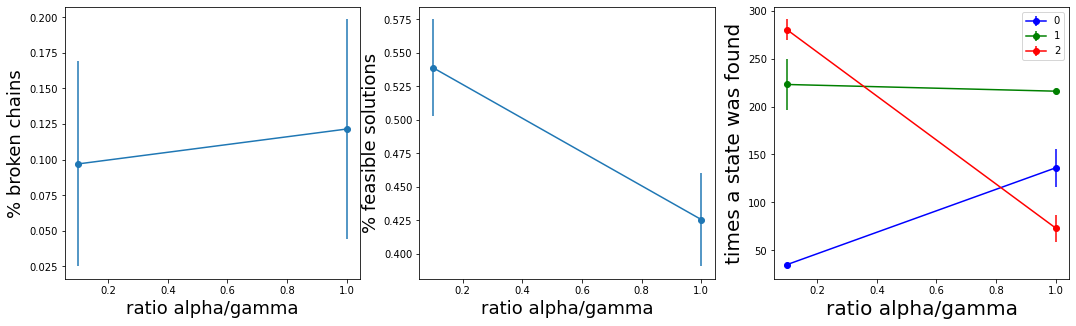

In [304]:
#FEASIBLE
import matplotlib.pyplot as plt

df_mean = df_all[df_all['weight_1'] == 1.].groupby('ratio w/l').mean()

color = ['b','g','r','c','m','y','k','tab:orange']

fig, axs = plt.subplots(1,3,figsize=(18, 5), sharey=False)

x = df_mean.index.values
y1 = df_mean['broken_chains'].to_numpy()
y2 = df_mean['ratio_feasible'].to_numpy()
all_energies = [-20.0, -19.0, -18.0]
labels = [str(x) for x in range(len(all_energies))]

y3 = []
error_y3 = []
error_bc = []
error_rf = []
for n,k in enumerate(x):
    df_tmp = df_all[df_all['ratio w/l'] == k]
    
    dist_average = np.array([0]*len(all_energies))
    all_dist = []
    error_bc.append(np.max(df_tmp['broken_chains'].to_numpy()) - np.min(df_tmp['broken_chains'].to_numpy()))
    error_rf.append(np.max(df_tmp['ratio_feasible'].to_numpy()) - np.min(df_tmp['ratio_feasible'].to_numpy()))
    for j in range(len(df_tmp['energy_distribution'].to_list())):
        distribution = []
        error = []
        for i in all_energies:
            v_energy = np.array([float(x) for x in df_tmp['energy_distribution'].to_list()[j].split(',')])
            v_mult = np.array([float(x) for x in df_tmp['multiplicity'].to_list()[j].split(',')])
            pos = np.where(np.round(v_energy,5) == np.round(i,5))[0]
            if len(pos) > 0:
                distribution.append(int(v_mult[pos[0]]))
            else:
                distribution.append(0)
        all_dist.append(distribution) 
    #print(all_dist)
    y3.append(np.average(np.array(all_dist),axis=0).astype(int).tolist())
    error_y3.append(np.max(all_dist,axis=0)-np.min(all_dist,axis=0))
y3 = np.array(y3)
error_y3 = np.array(error_y3)
for m in range(len(y3[0])):
    axs[2].errorbar(x,y3[:,m],yerr=error_y3[:,m],fmt='-o',color=color[m],label=labels[m])
    
    '''for m,k in enumerate(y3[0]):
    for en in range(len(x)):
        print(en,m)
        print(y3[en,m])
        axs[2].scatter(x[en], y3[en,m],label=labels[m],color=color[m])'''
    '''for m,y in enumerate(y3):
        if n == 0:
            axs[2].scatter(k, y,label=labels[m],color=color[m])
        else:
            axs[2].scatter(k, y,color=color[m])'''
axs[2].legend()
    
#axs[0].plot(x, y1,'-o')
axs[0].errorbar(x, y1, yerr = error_bc,fmt='-o')
axs[1].errorbar(x, y2,yerr = error_rf,fmt='-o')


axs[0].set_xlabel('ratio alpha/gamma', fontsize=18)
axs[1].set_xlabel('ratio alpha/gamma', fontsize=18)
axs[2].set_xlabel('ratio alpha/gamma', fontsize=20)
axs[0].set_ylabel('% broken chains', fontsize=18)
axs[1].set_ylabel('% feasible solutions', fontsize=18)
axs[2].set_ylabel('times a state was found', fontsize=20)
#fig.set_title('All feasible',fontsize=20)

#axs[:].set_xticks(np.arange(0,25))
#ax.set_yticks(np.arange(-50,0,5))
#plt.xticks(fontsize=12)
#plt.yticks(fontsize=16)

#fig.set_size_inches(15.5, 7.5)

plt.show()

### Broken chains

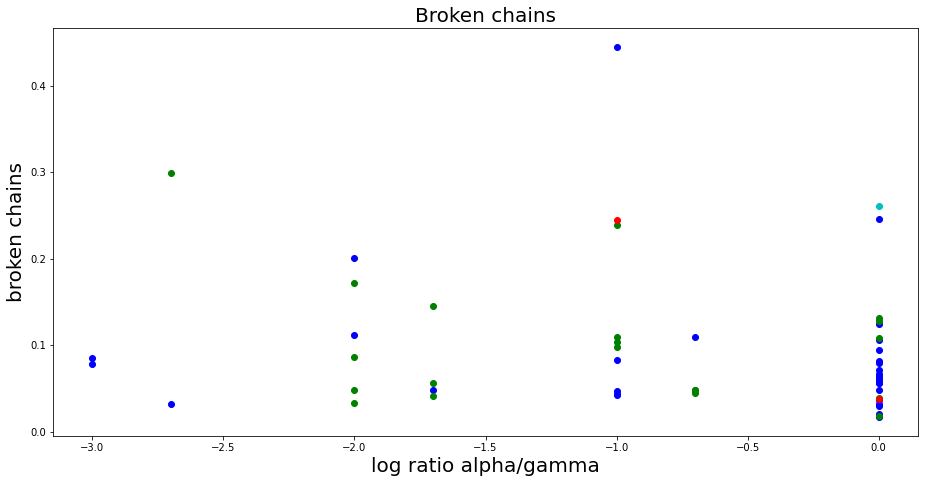

In [67]:
#BROKEN CHAINS
import matplotlib.pyplot as plt

color = ['b','g','r','c','m','y','k','tab:orange']
fig, ax = plt.subplots()

c_code = [int(np.log10(lx)) for lx in ratio_1v_df['weight_1'].to_numpy()]

index = -1

df = ratio_1v_df    

x = df['ratio w/l']
x = [np.log10(lx) for lx in x.to_numpy()]
y = df['broken_chains']

for i in range(len(x)):
    ax.plot(x[i],y[i],'o', color=color[c_code[i]])

ax.set_xlabel('log ratio alpha/gamma', fontsize=20)
ax.set_ylabel('broken chains', fontsize=20) 
ax.set_ybound()
ax.set_title('Broken chains',fontsize=20)

#ax.set_xticks(np.arange(0,18))
#ax.set_yticks(np.arange(-50,0,5))
#plt.xticks(fontsize=12)
#plt.yticks(fontsize=16)

fig.set_size_inches(15.5, 7.5)

plt.show()

# Chain strength

### All feasible

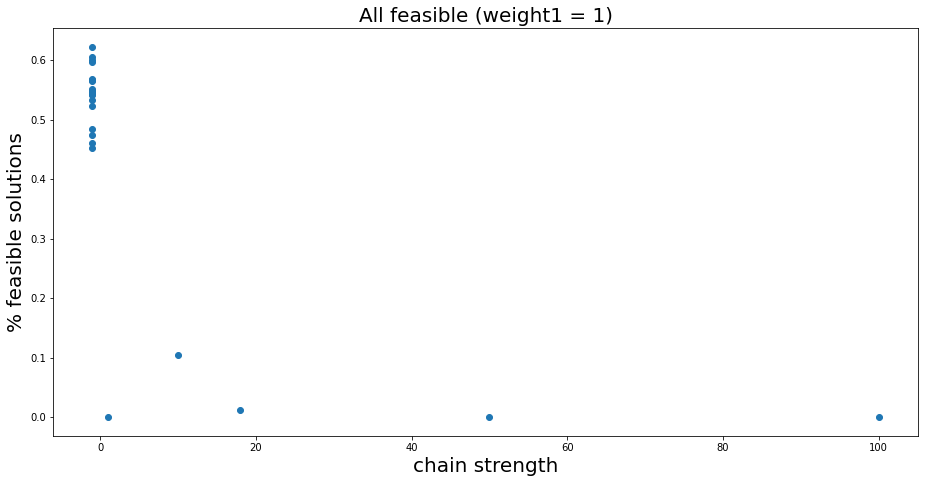

In [112]:
#FEASIBLE
import matplotlib.pyplot as plt

color = ['b','g','r','c','m','y','k','tab:orange']
fig, ax = plt.subplots()

c_code = [int(np.log10(lx)) for lx in ratio_1v_df['weight_1'].to_numpy()]

index = -1

df = ratio_cs_1v_df    

x = df['chain_strength'][:-1]
#x = [np.log10(lx) for lx in x.to_numpy()]
y = df['ratio_feasible'][:-1]


ax.plot(x,y,'o', )

ax.set_xlabel('chain strength', fontsize=20)
ax.set_ylabel('% feasible solutions', fontsize=20) 
ax.set_ybound()
ax.set_title('All feasible (weight1 = 1)',fontsize=20)

#ax.set_xticks(np.arange(0,18))
#ax.set_yticks(np.arange(-50,0,5))
#plt.xticks(fontsize=12)
#plt.yticks(fontsize=16)

fig.set_size_inches(15.5, 7.5)

plt.show()

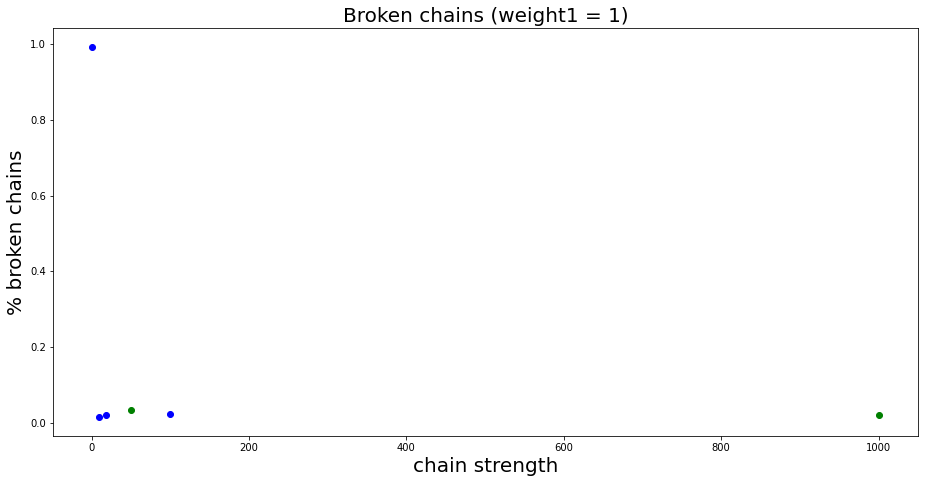

In [95]:
#BROKEN CHAINS
import matplotlib.pyplot as plt

color = ['b','g','r','c','m','y','k','tab:orange']
fig, ax = plt.subplots()

c_code = [int(np.log10(lx)) for lx in ratio_1v_df['weight_1'].to_numpy()]

index = -1

df = ratio_cs_1v_df    

x = df['chain_strength']
#x = [np.log10(lx) for lx in x.to_numpy()]
y = df['broken_chains']

for i in range(len(x)):
    ax.plot(x[i],y[i],'o', color=color[c_code[i]])

ax.set_xlabel('chain strength', fontsize=20)
ax.set_ylabel('% broken chains', fontsize=20) 
ax.set_ybound()
ax.set_title('Broken chains (weight1 = 1)',fontsize=20)

#ax.set_xticks(np.arange(0,18))
#ax.set_yticks(np.arange(-50,0,5))
#plt.xticks(fontsize=12)
#plt.yticks(fontsize=16)

fig.set_size_inches(15.5, 7.5)

plt.show()

## Absolute values $\alpha$, $\gamma$

In [17]:
a = df_all[df_all['num_vacancies'] == 1]
aa = a[a['chain_strength'] == -1]
b = aa[aa['weight_2'] == 0.]
ratio_av_1v_df = b[b['ratio w/l'] == 1].sort_values(by='weight_1')
#ratio_cs_1v_df = b.sort_values(by='chain_strength')
ratio_av_1v_df

,N atoms,num_vacancies,weight_1,weight_2,lagrange,ratio w/l,num_reads,broken_chains,ratio_feasible,energy_distribution,multiplicity,chain_strength
Values,18,1,1,0,1,1.0,1000,0.049,0.549,-24.0,549,-1
Values,18,1,1,0,1,1.0,1000,0.095,0.547,-24.0,547,-1
Values,18,1,1,0,1,1.0,1000,0.030,0.565,-24.0,565,-1
Values,18,1,1,0,1,1.0,1000,0.067,0.567,-24.0,567,-1
Values,18,1,1,0,1,1.0,1000,0.125,0.523,-24.0,523,-1
Values,18,1,1,0,1,1.0,1000,0.056,0.496,-24.0,496,-1
Values,18,1,1,0,1,1.0,1000,0.072,0.551,-24.0,551,-1
Values,18,1,1,0,1,1.0,1000,0.246,0.452,-24.0,452,-1
Values,18,1,1,0,1,1.0,1000,0.060,0.568,-24.0,568,-1
Values,18,1,1,0,1,1.0,1000,0.056,0.600,-24.0,600,-1


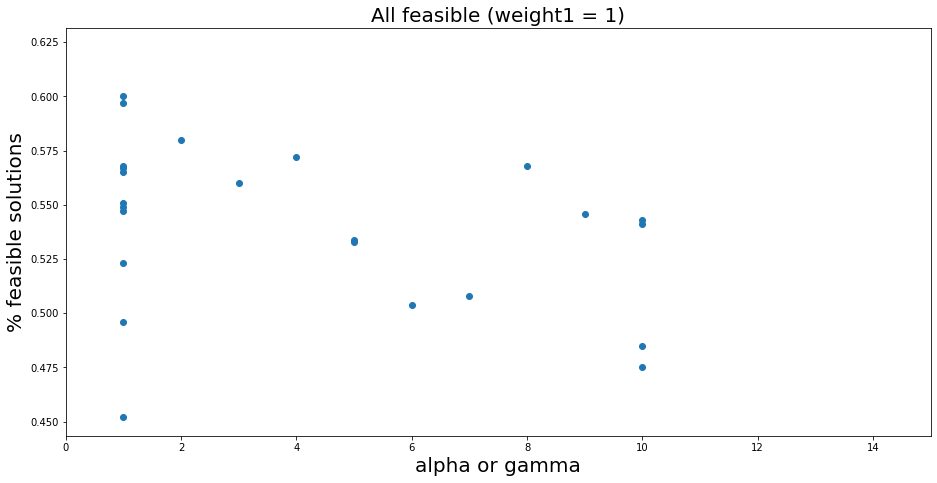

In [27]:
#FEASIBLE
import matplotlib.pyplot as plt

color = ['b','g','r','c','m','y','k','tab:orange']
fig, ax = plt.subplots()

c_code = [int(np.log10(lx)) for lx in ratio_av_1v_df['weight_1'].to_numpy()]

index = -1

df = ratio_av_1v_df    

x = df['weight_1'][:-1]
#x = [np.log10(lx) for lx in x.to_numpy()]
y = df['ratio_feasible'][:-1]


ax.plot(x,y,'o', )

ax.set_xlabel('alpha or gamma', fontsize=20)
ax.set_ylabel('% feasible solutions', fontsize=20) 
ax.set_ybound()
ax.set_xlim([0,15])
ax.set_title('All feasible (weight1 = 1)',fontsize=20)

#ax.set_xticks(np.arange(0,18))
#ax.set_yticks(np.arange(-50,0,5))
#plt.xticks(fontsize=12)
#plt.yticks(fontsize=16)

fig.set_size_inches(15.5, 7.5)

plt.show()

## Symmetry of answer

[0, 2, 5, 8, 13, 14] [1.  0.5 0.5 0.5 0.5 0.5] b
[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17] [0.39622642 0.50943396 0.37735849 0.79245283 0.32075472 0.52830189
 0.77358491 0.88679245 0.62264151 0.28301887 0.45283019 0.50943396
 0.58490566 0.49056604 0.9245283  1.         0.69811321 0.77358491] g
[0, 1, 2, 3, 4, 6, 7, 9, 10, 11, 14, 15, 16, 17] [0.14285714 0.42857143 0.57142857 0.42857143 0.42857143 0.42857143
 0.14285714 1.         0.57142857 0.14285714 0.42857143 0.14285714
 0.14285714 0.42857143] r
[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17] [0.50181818 0.69636364 0.45636364 0.42909091 0.63454545 0.51636364
 1.         0.41636364 0.32363636 0.49454545 0.50909091 0.54
 0.77454545 0.39272727 0.72363636 0.80363636 0.82545455 0.58363636] c


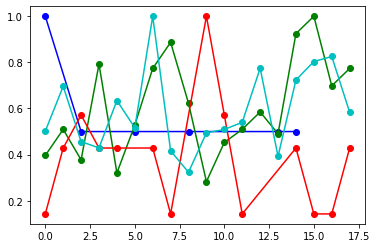

In [63]:
import os

directory = 'data/test_symmetry/'


color = ['b','g','r','c','m','y','k','tab:orange']
fig, ax = plt.subplots()

c_code = [int(np.log10(lx)) for lx in symm_1v_df['weight_1'].to_numpy()]

index = -1

for i,filename in enumerate(os.listdir(directory)):
    f = os.path.join(directory, filename)
    if os.path.isfile(f) and f.endswith(".json") and 'bqm' in f:
        #print(f)
        df, param = load_json(f,return_param = True, return_qubo = False)
        
        x = [x for x in np.where(equivalent_energy_distribution(df,energy=-24)[0] == 0)[1]]
        y = equivalent_energy_distribution(df,energy=-24)[1]/max(equivalent_energy_distribution(df,energy=-24)[1])
        print(x,y,color[i])
        ax.plot(x,y,'-o', color=color[i])

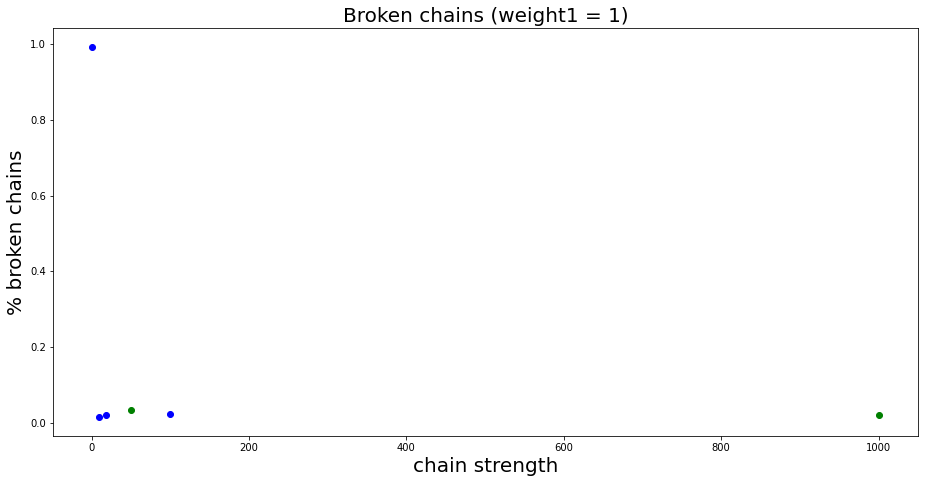

In [95]:
#BROKEN CHAINS
import matplotlib.pyplot as plt

color = ['b','g','r','c','m','y','k','tab:orange']
fig, ax = plt.subplots()

c_code = [int(np.log10(lx)) for lx in symm_1v_df['weight_1'].to_numpy()]

index = -1

df = symm_1v_df    

x = df['chain_strength']
#x = [np.log10(lx) for lx in x.to_numpy()]
y = df['broken_chains']

for i in range(len(x)):
    ax.plot(x[i],y[i],'o', color=color[c_code[i]])

ax.set_xlabel('chain strength', fontsize=20)
ax.set_ylabel('% broken chains', fontsize=20) 
ax.set_ybound()
ax.set_title('Broken chains (weight1 = 1)',fontsize=20)

#ax.set_xticks(np.arange(0,18))
#ax.set_yticks(np.arange(-50,0,5))
#plt.xticks(fontsize=12)
#plt.yticks(fontsize=16)

fig.set_size_inches(15.5, 7.5)

plt.show()

In [53]:
ratio_feasible(a,num_vacancies=1,remove_broken_chains=False)

0.183

[]


TypeError: tuple indices must be integers or slices, not str

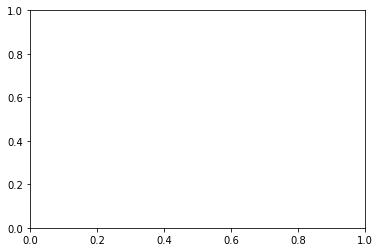

In [291]:
import matplotlib.pyplot as plt

color = ['b','g','r','c','m','y','k','tab:orange']
fig, ax = plt.subplots()
    
index = -1
directory = './data/symmetry/'
for filename in os.listdir(directory):
    f = os.path.join(directory, filename)
    if os.path.isfile(f):# and f.endswith(".json"):
        run = int(f[53:-19])
        df = load_json(f)
        index += 1
        
        config, multiplicity = equivalent_energy_distribution(df[0],energy=-24.)
        print(config)
        x = df['lagrange']
        x = [np.log10(lx) for lx in x.to_numpy()]
        y = df['ratio_feasible']

        ax.plot(x,y,'o', color=color[index])

ax.set_xlabel('Lagrange (log)', fontsize=20)
ax.set_ylabel('% feasible solutions', fontsize=20) 
ax.set_ybound()

#ax.set_xticks(np.arange(0,18))
#ax.set_yticks(np.arange(-50,0,5))
#plt.xticks(fontsize=12)
#plt.yticks(fontsize=16)

fig.set_size_inches(18.5, 10.5)

plt.show()

In [274]:
directory = './data/symmetry/'
for filename in os.listdir(directory):
    f = os.path.join(directory, filename)
    if os.path.isfile(f):# and f.endswith(".json"):
        print(f[53:-19])

2500
500
2000
100
1500
1000


In [ ]:
config_all, energy_all, multiplicity_all = find_all_structures(dataframe, sort_config=True)

In [ ]:
np.sum(multiplicity_all)

## Chain strength

## Exact solver

In [15]:
import os

directory = 'data/test/'

dataframes = []

for filename in os.listdir(directory):
    f = os.path.join(directory, filename)
    if os.path.isfile(f) and f.endswith(".json") and 'bqm' in f:
        #print(f)
        df, param = load_json(f,return_param = True, return_qubo = False)
        if np.sum(df['chain_break_fraction']==0.) > 0:
            param = param.transpose()
            n_vac = param['num_vacancies'].values[0]
            n_atoms = param['N atoms'].values[0]
            param['broken_chains'] = find_ratio_broken_chains(df)
            #param['ratio_feasible'] = ratio_feasible(df,param['num_vacancies'].values[0],remove_broken_chains=False)   
            param['ratio_feasible_nb'] = find_ratio_feasible(df,param['num_vacancies'].values[0], remove_broken_chains=True)   
            param['ratio_feasible'] = find_ratio_feasible(df,param['num_vacancies'].values[0], remove_broken_chains=False)
            param['energy_distribution_all'] = ', '.join(str(x) for x in find_energy_distribution(df)[0])
            param['multiplicity_all'] = ', '.join(str(x) for x in find_energy_distribution(df)[1])        
            param['energy_distribution'] = ', '.join(str(x) for x in find_energy_distribution(df, only_feasible=True, vacancies=param['num_vacancies'].values[0])[0])
            #param['num_broken_bonds'] = ', '.join(str(x) for x in calc_num_broken_bonds(dataframe, remove_broken_chains = True, only_feasible = True, vacancies = param['num_vacancies'].values[0]))
            param['multiplicity'] = ', '.join(str(x) for x in find_energy_distribution(df, only_feasible=True, vacancies=param['num_vacancies'].values[0])[1])
            param['ratio w/l'] = param['weight_1'] / param['lagrange']
            #print(energy_distribution(df, only_feasible=True, vacancies=n_vac))
            '''if energy_distribution(df, only_feasible=True, vacancies=n_vac)[0][0] == -(-1 - n_vac*2+n_atoms*1.5):
                param['min_found'] = True
            else:
                param['min_found'] = False'''
            if 'chain_strength' not in param:
                param['chain_strength'] = -1
            #print(param['chain_strength'])
            if param['chain_strength'].all() == None:
                param['chain_strength'] = -1
                print('YES')
            dataframes.append(param)
        else:
            print('Broken: ',f)
df_results = pd.concat(dataframes)